#Face Mask Detection using Fastai and Opencv

Importing fastbook and related modules

In [1]:
!pip install -Uqq fastbook
import fastbook

     |████████████████████████████████| 727kB 9.7MB/s 
     |████████████████████████████████| 1.2MB 38.6MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 194kB 54.2MB/s 
     |████████████████████████████████| 61kB 11.2MB/s 
     |████████████████████████████████| 61kB 10.9MB/s 


In [2]:
from fastai.vision.all import *
from fastbook import *

Downloading the dataset from https://www.kaggle.com/andrewmvd/face-mask-detection'. This dataset consists of 853 images and their corresponding annotation files. Each annotation file contains the location of the faces and their label: 'with_mask',  'without_mask' or 'mask_weared_incorrect'

In [3]:
creds = '{"username":"surajgiri","key":"4ac020c2e0b9460dae4c2463c5f69a09"}'

In [4]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [5]:
from kaggle import api

In [6]:
api.dataset_download_files('andrewmvd/face-mask-detection', path='data', unzip=True)

# Data Preprocessing

Reading the images and annotations

In [7]:
path = Path('data')
images = (path/'images').ls().sorted()
annots = (path/'annotations').ls().sorted()

Reading data from annotations.xml files using bs4, using the data to crop faces from images and place them in folders according to their labels.

In [8]:
import numpy as np
import bs4, lxml
from PIL import Image

In [9]:
c=0

path = Path('Classified Images')
if not path.exists():
  path.mkdir()

for i in range(len(images)):

    with open(annots[i],'r') as f:
        data = f.read()

    soup = bs4.BeautifulSoup(data, 'xml')
    objects = soup.select('object')
    
    img = Image.open(images[i])
    imgArray = np.array(img)
    
    for j in range(len(objects)):
        xmin, ymin, xmax, ymax = [int(x) for x in soup.select('bndbox')[j].getText().split('\n')[1:-1]]
        label = soup.select('name')[j].getText()
        face = imgArray[ymin:ymax, xmin:xmax]
        face = Image.fromarray(face)
        
        dest = path/label
        dest.mkdir(exist_ok=True)
        imgName = 'img' + str(c) + '.png'
        face.save(dest/imgName)
        c+=1

#Training a CNN model using Fastai

Applying some transformations to the images and creating Dataloaders object for training

In [10]:
masks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                 splitter = RandomSplitter(valid_pct=0.2),
                 get_y = parent_label,
                 item_tfms = RandomResizedCrop(224, min_scale=0.5),
                batch_tfms = aug_transforms())

In [11]:
dls = masks.dataloaders(path, bs=64)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


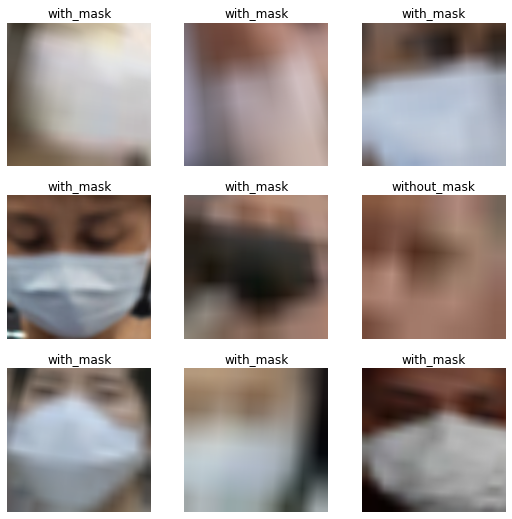

In [12]:
dls.train.show_batch()

Using the pretrained cnn_learner from Fastai for transfer learning

In [13]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=tensor(0.0025))

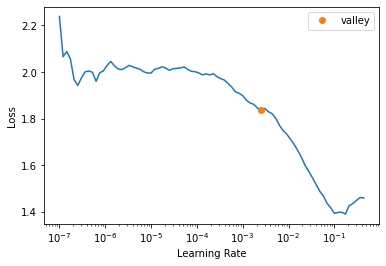

In [14]:
learn.lr_find()

In [15]:
learn.fit_one_cycle(5, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.451869,0.743018,0.749386,00:13
1,0.952699,0.357442,0.904177,00:13
2,0.596449,0.263661,0.934889,00:13
3,0.422406,0.238460,0.936118,00:13
4,0.343653,0.238412,0.933661,00:13


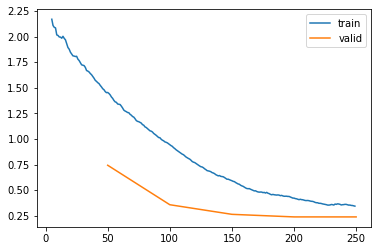

In [16]:
learn.recorder.plot_loss()

Interpreting our model

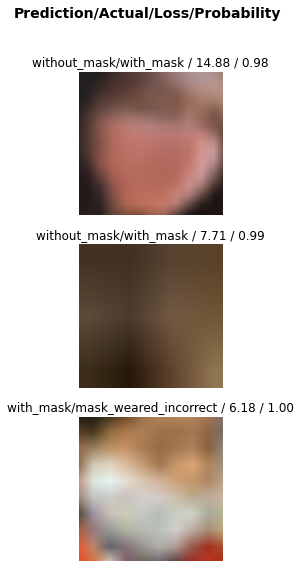

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(3, nrows=3)

Here we can see that top losses are in low resolution images which is fine.

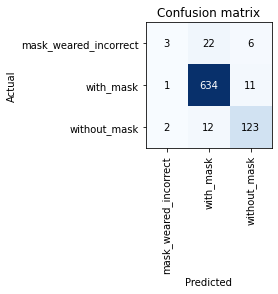

In [18]:
interp.plot_confusion_matrix()

Here, we see that the most common mistake our model makes is mistaking the people wearing the masks incorrectly as correctly which is understandable as it is very difficult to predict.

Saving our model for future use

In [19]:
save_pickle(path/'learn.pkl',learn)